# Projet Fil <span style='color:red'> Rouge  </span> 2023 : Reconnaissance de commandes audio

**Last name :** Besbes & Rool

**First Name :** Inès & Sara

**Name of the pair :** Besbouilla

**Summary :**
- I) Preprocessing
- II) Multiclass regression
- III) Classification by kernel methods
- IV) Classification by ensemble methods
- V) Neural networks

# I) Preprocessing

## Import utils

Nous avons packager toutes nos functions et import dans utils.py

In [1]:
import utils
from utils import *
import importlib

In [2]:
importlib.reload(utils)

<module 'utils' from '/home/sara/fil rouge ml/utils.py'>

## Import & trim data

From moodle, we import a file of audio recordings of command words for a quadcopter drone made up of several male speakers (denoted M01..M13) and female speakers (F01..F05) for a few commands. We trim the recordings to isolate the word and have identical durations.

In [3]:
data = [] 
label = [] 
genres = []
min_duration = None
words = ['avance','recule','tournegauche']
list_genres = ['M', 'F']

for file_name in glob.glob('FichierTest/*.wav'):
    record = librosa.load(file_name)[0]
    data.append(record)
    # Computation of the minimal size of recordings
    if min_duration is None or record.shape[0] < min_duration:
        min_duration = record.shape[0] 
    
    # Creation of the vector of label
    for i, word in enumerate(words):
      if re.search(word, file_name):
        label.append(i)

    # Creation of the vector of label
    for i, genre in enumerate(list_genres):
      if re.search(genre, file_name[12:]):# 12 is for ignoring "FichierTest/"
        genres.append(genre)

fs = librosa.load(file_name)[1] # Sampling frequency
genres = np.array(genres)
print(f'The smallest record contains {min_duration} samples, and the sample frequency is {fs} Hz')


The smallest record contains 18522 samples, and the sample frequency is 22050 Hz


In [4]:
def trim(record):
    half_duration = 18522//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [5]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i])

y = np.array(label)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(54, 18522) and size of targets class is (54,)


## Dimension reduction

We use spectral representation to reduce the dimension of our data. Indeed, we have at the beginning 54 signals of 18522 data each. It is important to reduce the dimension before applying classifiers to <b>facilitate their performance and results</b>.

For this, we implement 2 methods: 

- FFT & PCA
- STFT


### FFT & PCA

The FFT helps transform signals to extract relevant frequency-based features. The PCA reduces the dimensionality of the extracted features, making processing and analysis more efficient while minimizing information loss.
This combination is particularly useful for signal processing and pattern recognition, allowing for more compact and manageable data without losing essential information.

In [6]:
X_fft = fft(X)
pca = PCA()
pca.fit(np.absolute(X_fft.T)) #we take the module of X_fft

PCA()

In [7]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(54)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
).rename(columns = {'% cum. var. expliquée' : '% cumulative variance'})

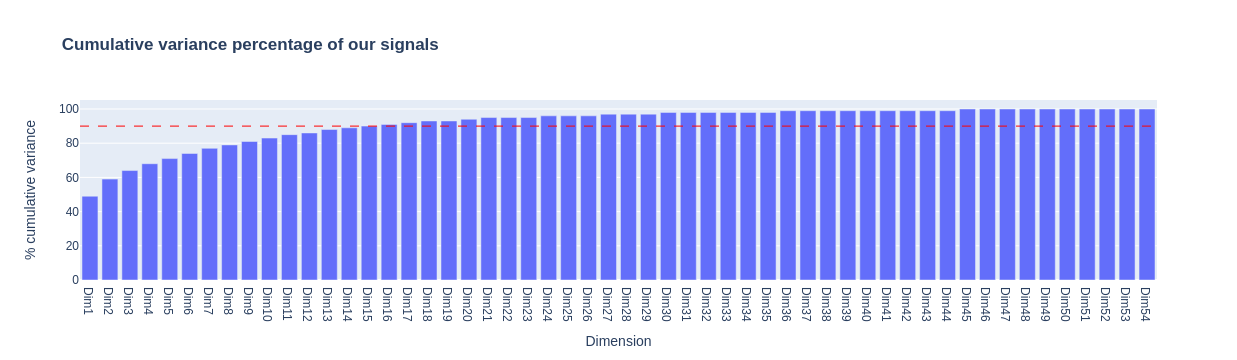

In [8]:
fig = px.bar(eig, x="Dimension", y="% cumulative variance", title='<b>Cumulative variance percentage of our signals</b>')
fig.add_hline(y=90, line_width=1, line_dash="dash", line_color="red")
fig.show()

<div class="alert alert-block alert-info">
With the graph au desus, we decide to keep 15 components.
</div>

### STFT

The Short-Time Fourier Transform (STFT) is a technique that allows for analyzing the frequency variations of a signal over time. It involves dividing the signal into short time segments and applying the Fourier Transform to each segment.

In [9]:
nperseg = 253
f, t, X_stft = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)

(127, 147)


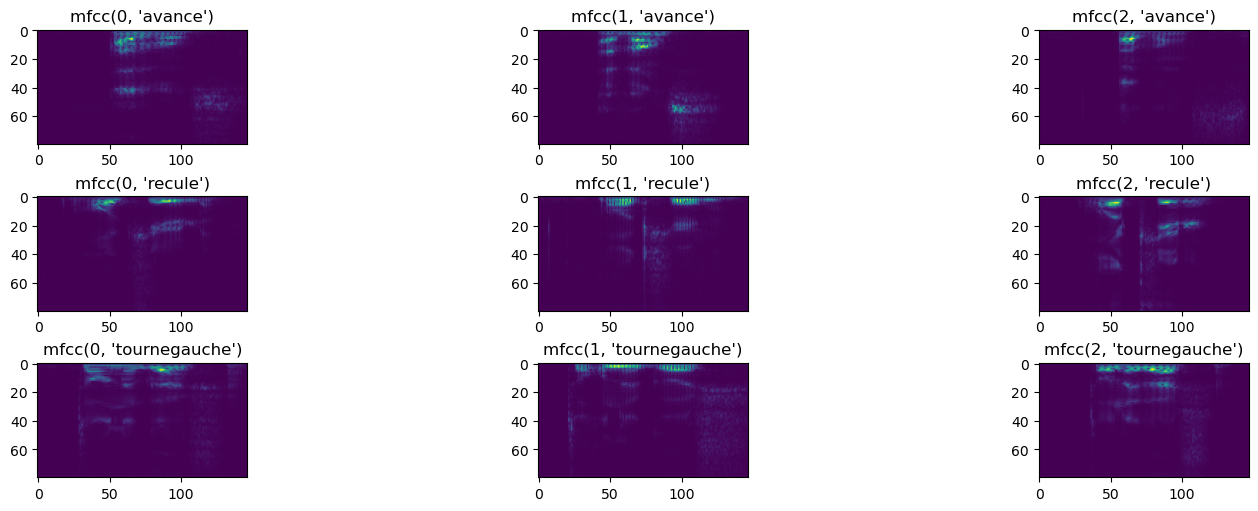

In [10]:
fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'M')][instance]
        f, t, Zxxm = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxxm[:80])) # we cut the frequencies here
        axs[i,instance].set_title(f'mfcc{instance,word}')

        
print(Zxxm.shape)
plt.show()

(127, 147)


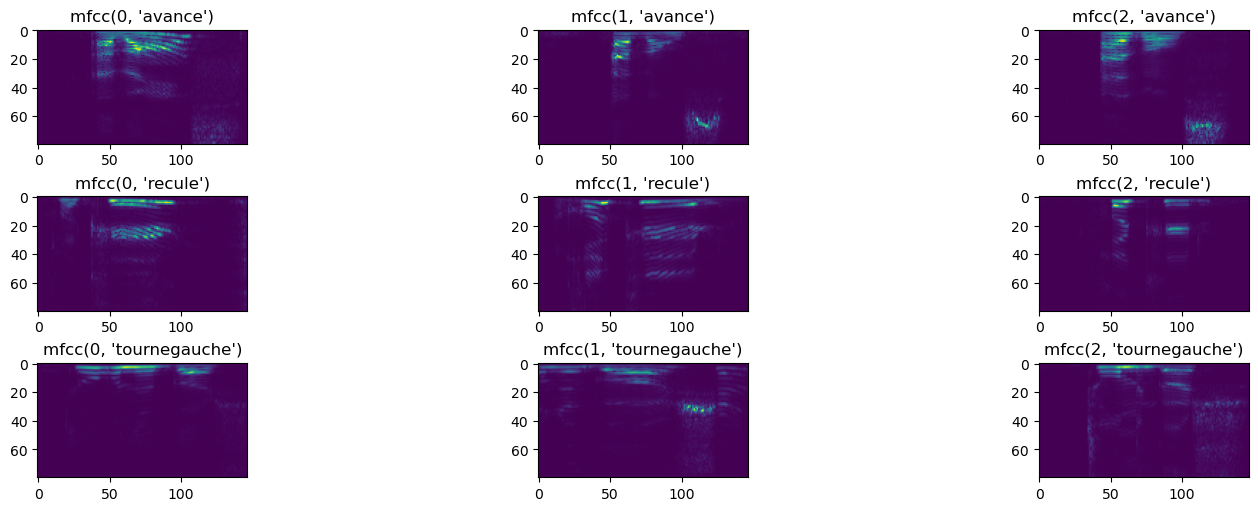

In [11]:
fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'F')][instance]
        f, t, Zxxf = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxxf[:80])) # we cut the frequencies here
        axs[i,instance].set_title(f'mfcc{instance,word}')

        
print(Zxxf.shape)
plt.show()

<div class="alert alert-block alert-info">
The dimension of X after the STFT and without cutting frequencies is (127, 168).

We notice that we can cut the frequencies at 80 because there is no information beyond.
</div>

### Class construction


We define 2 classes: FFT and STFT. We need this to be able to use transform functions in our pipelines that are not defined in the python functions.

In [12]:
class FFT(BaseEstimator, TransformerMixin):
    def __init__(self, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.absolute(fft(X)[:self.idx_frequence_max])

In [13]:
class STFT():
    def __init__(self, idx_frequence_max = None, stat = None):
        self.idx_frequence_max = idx_frequence_max    
        self.stat = stat
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        nperseg = 253
        f, t, Zxxm = signal.stft(X, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        Zxxm_trans = np.absolute(Zxxm[:, :self.idx_frequence_max, :])
        X_trans = np.zeros((Zxxm_trans.shape[0],Zxxm_trans.shape[1]))
        for s in range(Zxxm_trans.shape[0]):
            for i in range(Zxxm_trans.shape[1]):
                X_trans[s, i] = self.stat(Zxxm_trans[s,i,:])
        return X_trans

    #usefull to use pipeline
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# II) Multiclass regression

In this part, we consider a logistic regression model.


We model the probabilities by the following form :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } {1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
For all $j$ in $\{ 1,2, \dots , K-1 \}$.


### Cross validation from scratch

#### To better understand cross validation, we implement the function ourselves. We will then use the already existing functions. We also decided to implement other functions to simplify the display in py.

This <b>CrossValidation</b> function takes as input the X, y and the coefficient C for the logistic regression. Then returns the mean_accuracy_train, mean_accuracy_test, y_test and y_pred_test.

In [13]:
def CrossValidation(X, y, C, n = 3):
    #shuffle indexs
    idx = np.arange(X.shape[0])
    idx = shuffle(idx)
    Xs = X[idx]
    ys = y[idx]

    #we divide into 3 sets
    n_folds = n
    l = Xs.shape[0]
    X_test = []
    X_train = []
    y_test = []
    y_train = []
    for i in range(n_folds):
        idx_test = idx[round(l*i/n_folds):round(l*(i+1)/n_folds)]
        idX_train = idx.tolist()
        for j in idx_test:
            idX_train.remove(j)
        X_test.append(Xs[idx_test, :])
        X_train.append(Xs[idX_train, :])
        y_test.append(ys[idx_test])
        y_train.append(ys[idX_train])

    #model instanciation
    model = LogisticRegression(C = C, max_iter = 1000)

    #computing the score
    score_test = []
    score_train = []
    for i in range(n_folds):
        model.fit(X_train[i], y_train[i])
        y_pred_train = model.predict(X_train[i])
        y_pred_test = model.predict(X_test[i])
        fold_score_test = accuracy_score(y_test[i], y_pred_test)
        score_test.append(fold_score_test)
        fold_score_train = accuracy_score(y_train[i], y_pred_train)
        score_train.append(fold_score_train)
    mean_accuracy_test = np.mean(score_test)
    mean_accuracy_train = np.mean(score_train)
    return mean_accuracy_test, mean_accuracy_train, y_test, y_pred_test

### Results on initial data

We apply the algorithm directly to the data without transformations. We then see overfitting which gives poor results on the prediction of the test data but very good results on the training data (hence the overfitting).

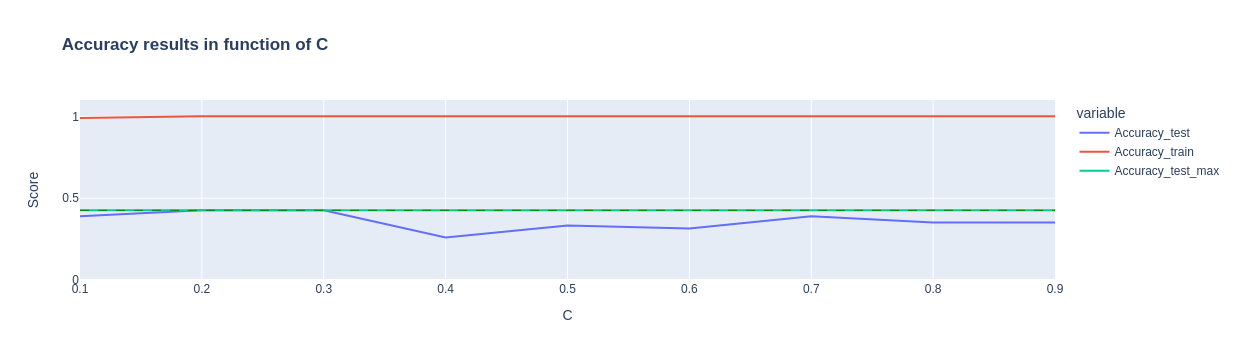

The best test score is : 0.4259259259259259


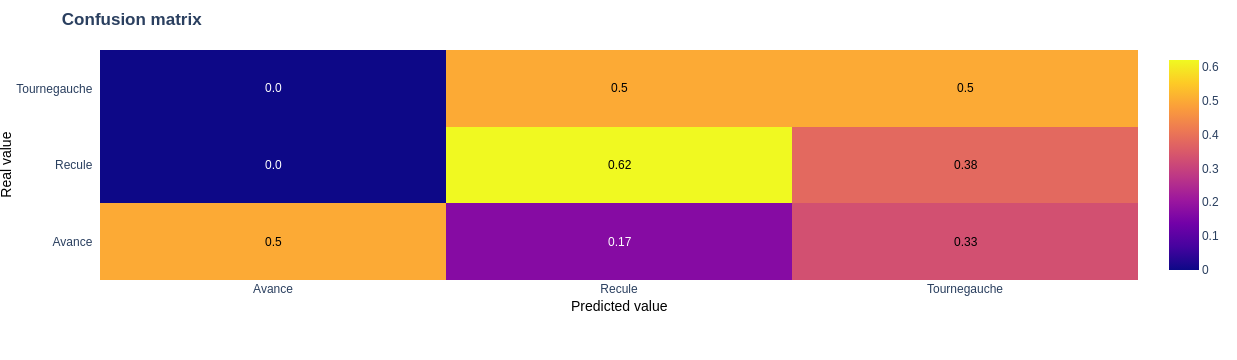

In [30]:
df_initial_data = df_C_variation(X, y, 0.1, 1, 0.1)
plot_accuracy(df_initial_data)
confusion_matrix_from_df(df_initial_data)

<div class="alert alert-block alert-info">
We notice thanks to the confusion matrix above that our data is very poorly classified. We must therefore necessarily modify our data.
</div>

### Results on FFT & PCA data

We apply the regression model to our data transformed by FFT & PCA. We kept <b>15 dimensions</b> from the PCA.

In [33]:
pca = PCA(n_components=15)
X_pca = pca.fit(np.absolute(X_fft.T)).components_.T

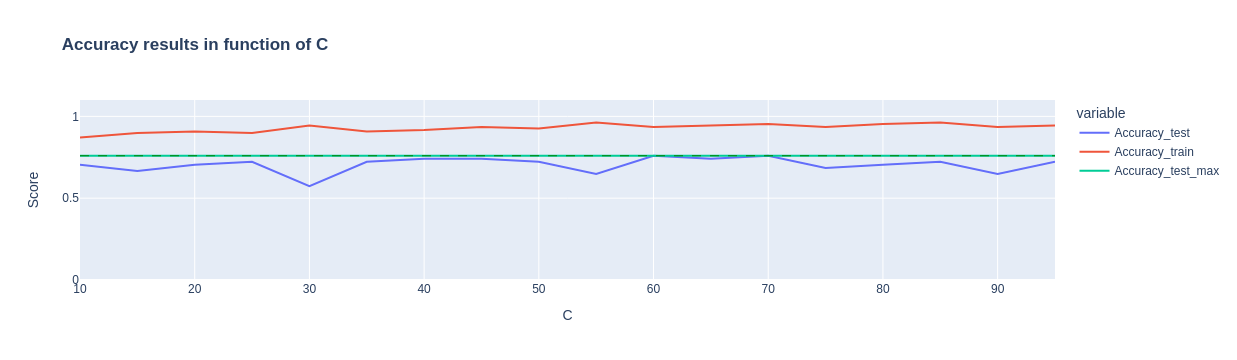

The best test score is : 0.7592592592592592


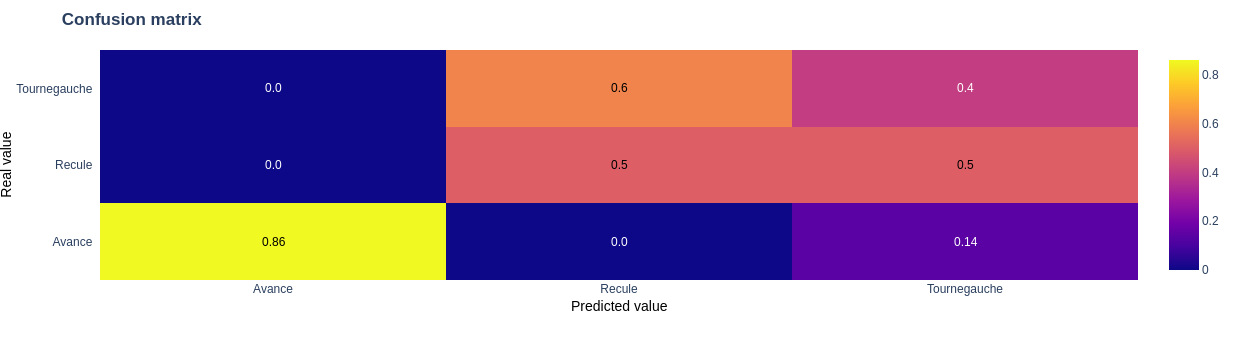

In [34]:
df_fft_pca_data = df_C_variation(X_pca, y, 10, 100, 5)
plot_accuracy(df_fft_pca_data)
confusion_matrix_from_df(df_fft_pca_data)

<div class="alert alert-block alert-info">
We see that our data is much better classified. In fact, we classified correctly 70% of the time. We also notice that we no longer have any overfitting.</div>

### Results on STFT data

We do the same thing as before but on our data modified by STFT. We fixe the max frequency at 90 and we chose np.mean as statistics.

In [35]:
stft = STFT(idx_frequence_max = 90, stat = np.mean)
X_stft = stft.transform(X)

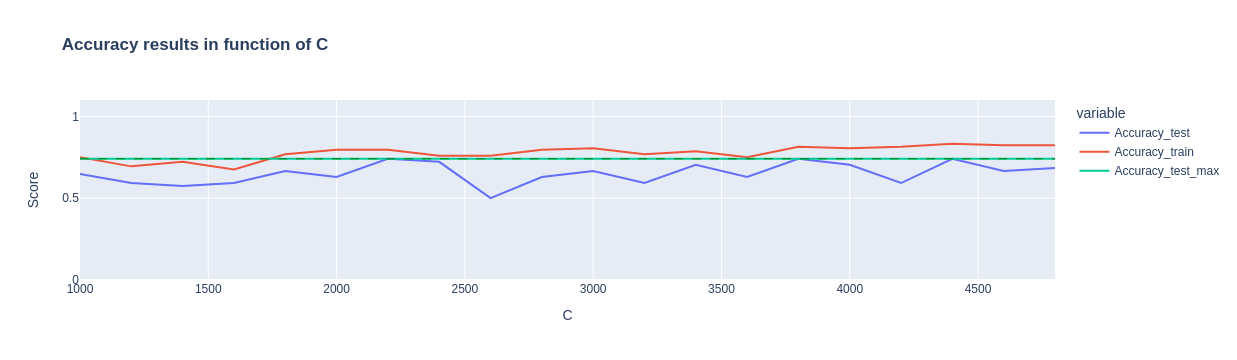

The best test score is : 0.7407407407407408


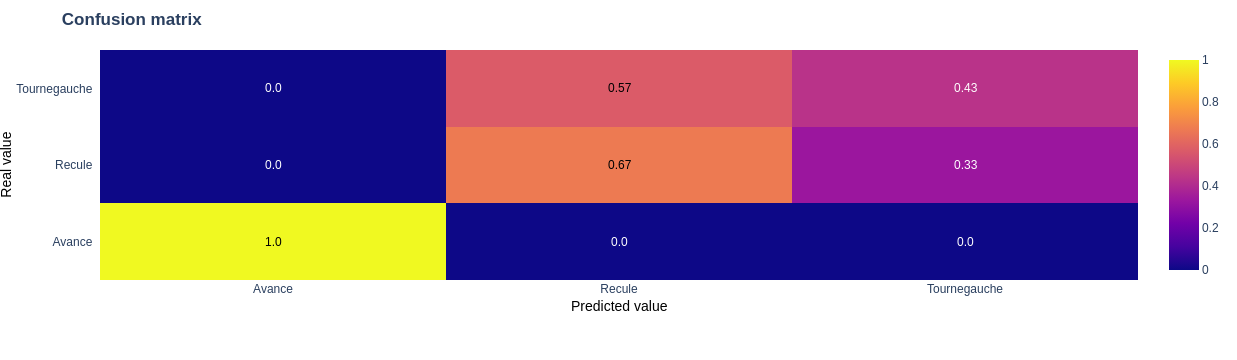

In [36]:
df_stft_data = df_C_variation(X_stft, y, 1000, 5000, 200)
plot_accuracy(df_stft_data)
confusion_matrix_from_df(df_stft_data)

<div class="alert alert-block alert-info">
Similar results are obtained when using FFT & PCA. These predictions are satisfactory. There's no overfitting. </div>

### Results on STFT & Scaling

This time, we scale our data after applying the stft.

In [37]:
scaler_stft = StandardScaler()
X_stft_scale = scaler_stft.fit_transform(stft.transform(X))

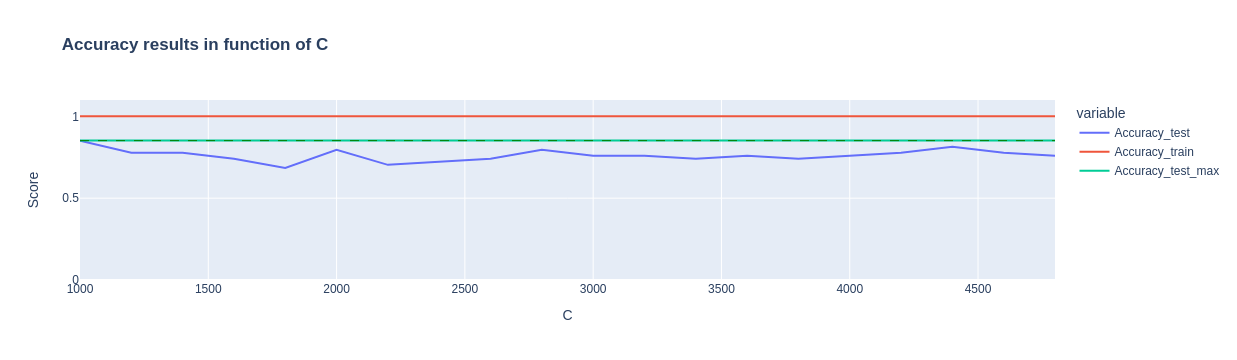

The best test score is : 0.8518518518518517


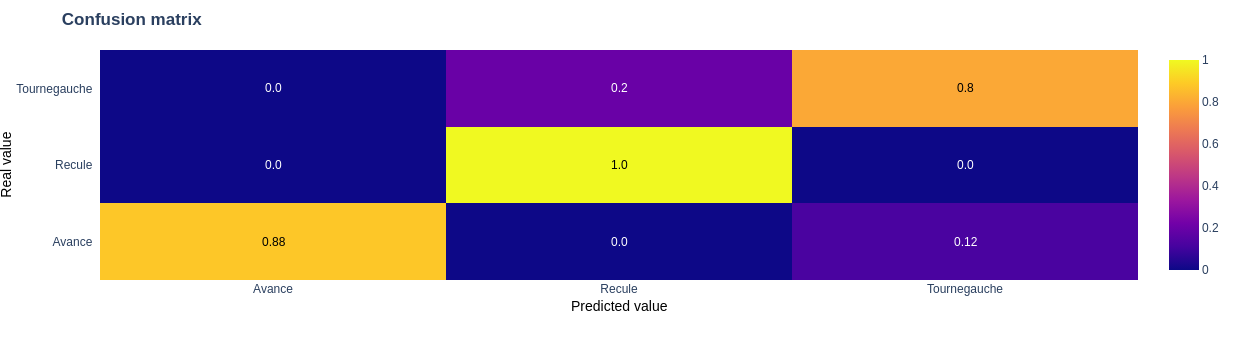

In [38]:
df_stft_scale_data = df_C_variation(X_stft_scale, y, 1000, 5000, 200)
plot_accuracy(df_stft_scale_data)
confusion_matrix_from_df(df_stft_scale_data)

<div class="alert alert-block alert-info">
By scaling our data, we obtain very good predictions. We obtain a maximum accuracy of 90%. And we see that our confusion matrix is ​​pretty accurate.</div>

<div class="alert alert-block alert-info">
Indeed, scaling data before performing logistic regression is important for several reasons:

- Improved Convergence
- Coefficients Interpretation
- Avoiding Numerical Issues
- Distance-Based Algorithms: Logistic regression can be influenced by the distances between points in the feature space.
</div>

## Cross validation using GridSearchCV

In a similar way, we find the previous results but using the functions already existing in Python. This will allow us to test different coefficients.

### Find the best logistic regression model & parameters

First, we need to create all the necessary commands. For that, we create a fonction that add a model to the following pipeline : 
    
- pipe_1 : FFT + PCA + model
- pipe_2 : FFT + scale + PCA + model
- pipe_3 : STFT + model
- pipe_4 : STFT + scale + model

We also need to create the param_grid/values associated with each pipeline.

In [14]:
param_grid_log_reg = [{
    "pca__n_components": [15, 20],
    "logistic__C": [1, 10, 100, 500],
},

{
    "pca__n_components": [15, 20],
    "logistic__C": [1,10, 50, 100, 150,],
},

{
    "logistic__C": [500, 600, 700, 800],
    "stft__stat": [np.mean, np.max, np.median, np.min, np.std],
    "stft__idx_frequence_max": [90, 95],
},

{
    "logistic__C": [0.5, 1, 1.5, 5],
    "stft__stat": [np.mean, np.max, np.median, np.min, np.std],
    "stft__idx_frequence_max": [95, 100],
}]

In [15]:
logistic = LogisticRegression(max_iter=10000, random_state = 42)

In [16]:
clfs_logistic_regression = set_pipelines(X, y, logistic, 'logistic', param_grid_log_reg)

### Results on FFT & PCA data

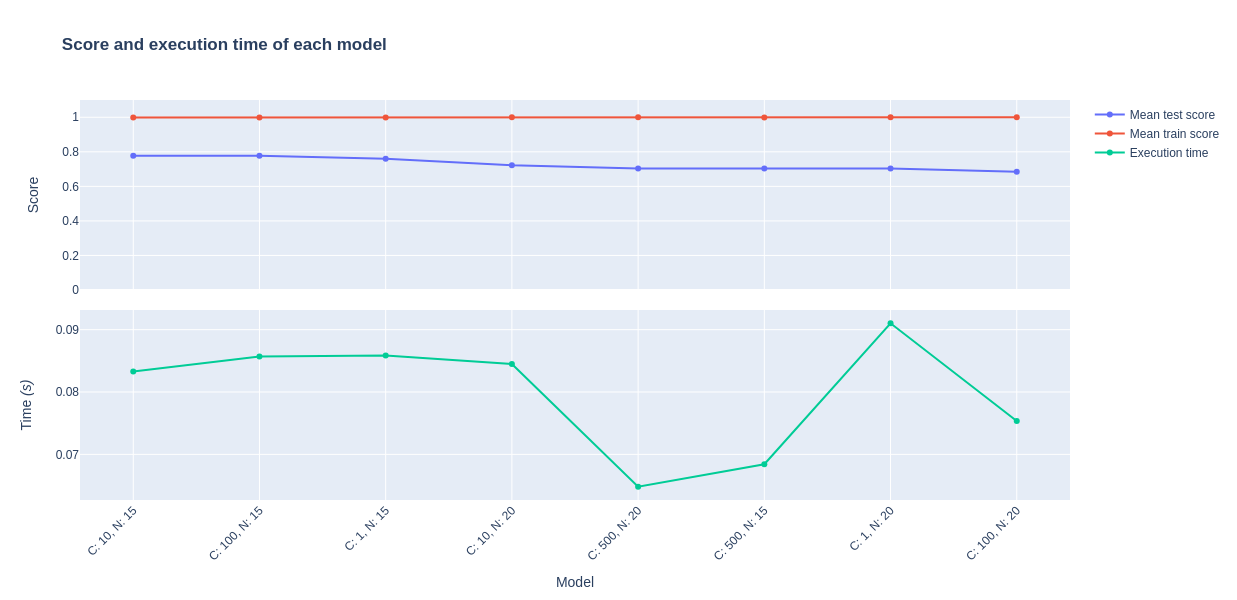

Best parameters: {'logistic__C': 10, 'pca__n_components': 15}
Best score: 0.7777777777777778


In [17]:
plot_score_time_clf(clf_transform(clfs_logistic_regression[0], "reg_1"))

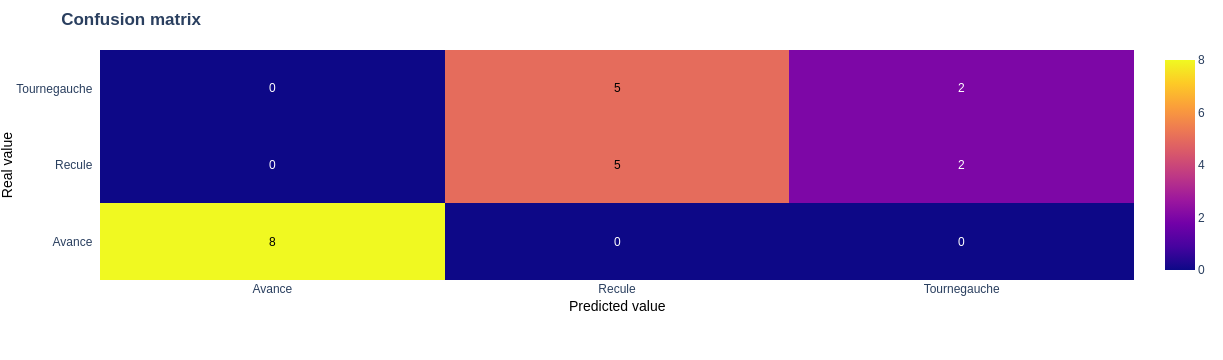

In [18]:
confusion_matrix_clf(clfs_logistic_regression[0], X, y)

### Results on FFT & Scale & PCA data

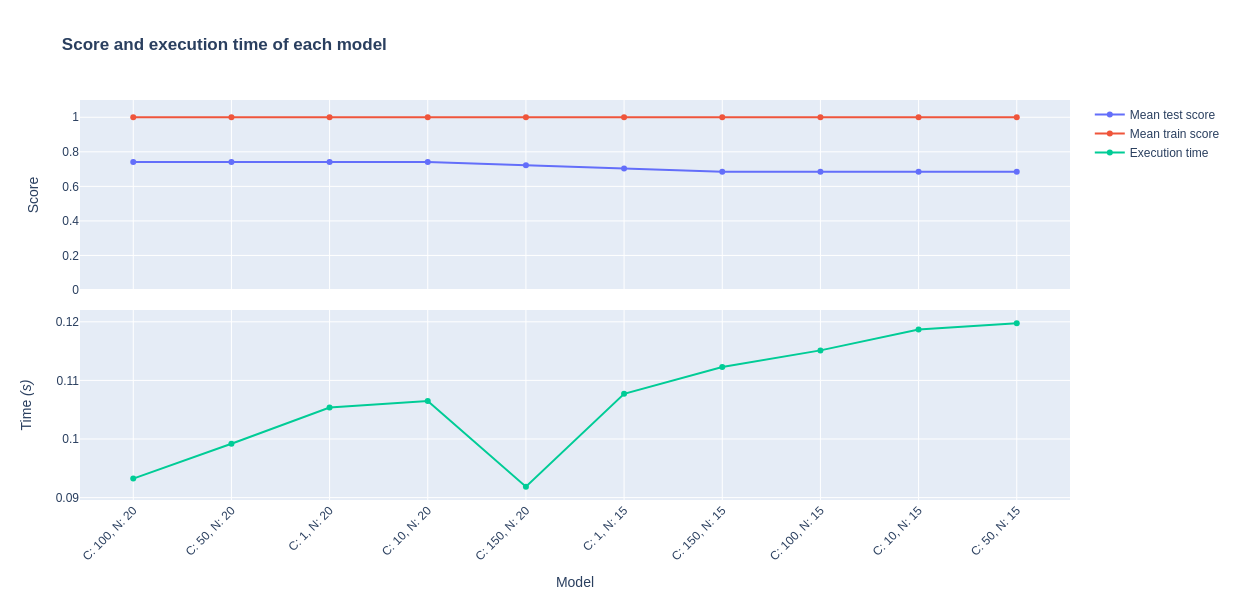

Best parameters: {'logistic__C': 1, 'pca__n_components': 20}
Best score: 0.7407407407407407


In [19]:
plot_score_time_clf(clf_transform(clfs_logistic_regression[1],"reg_1"))

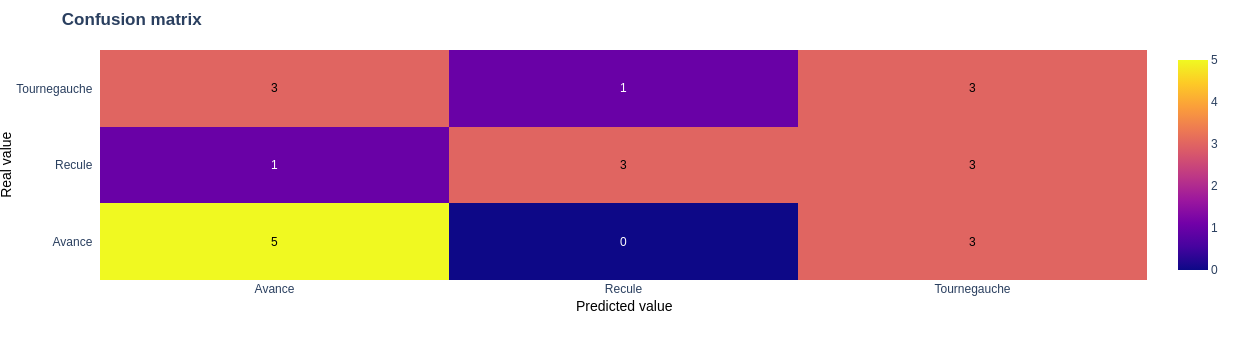

In [20]:
confusion_matrix_clf(clfs_logistic_regression[1], X, y)

### Results on STFT data

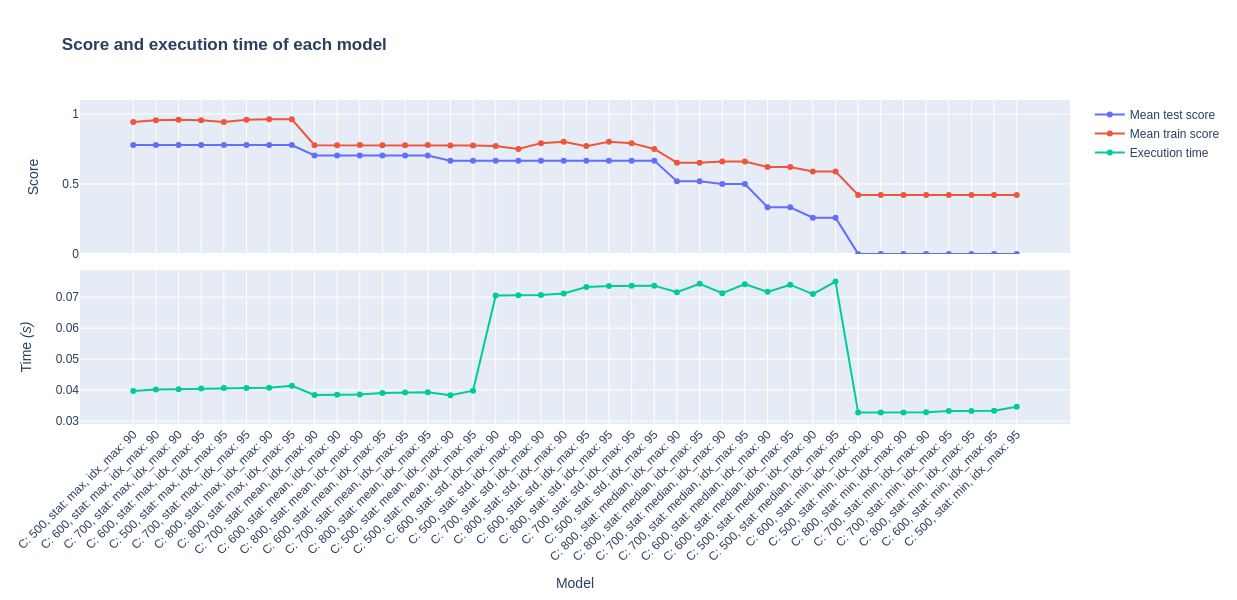

Best parameters: {'logistic__C': 500, 'stft__idx_frequence_max': 90, 'stft__stat': <function max at 0x771c917519f0>}
Best score: 0.7777777777777778


In [21]:
plot_score_time_clf(clf_transform(clfs_logistic_regression[2], "reg_2"))

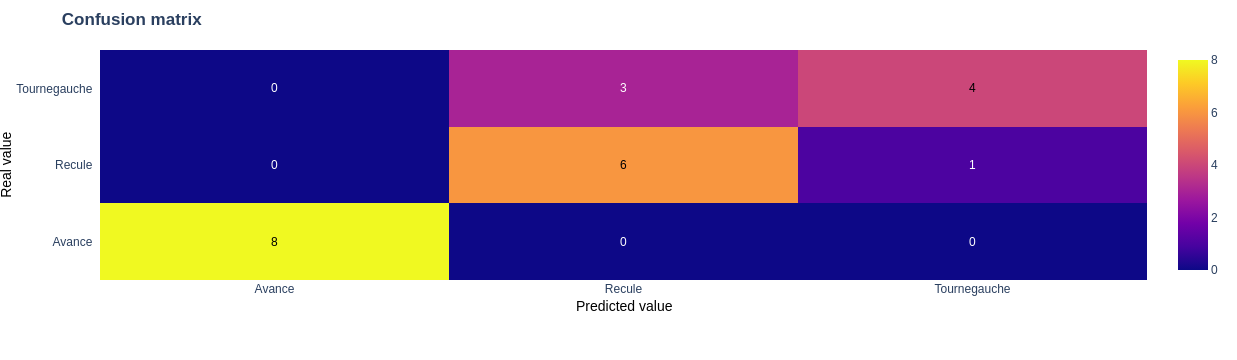

In [22]:
confusion_matrix_clf(clfs_logistic_regression[2], X, y)

### Results on STFT & Scale data

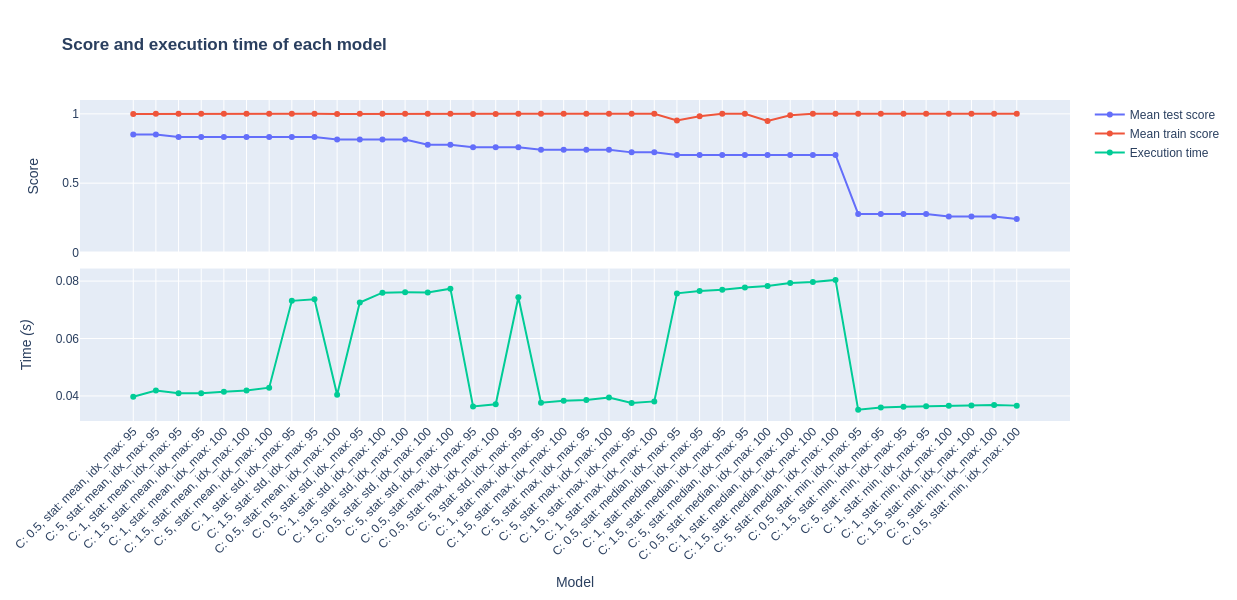

Best parameters: {'logistic__C': 0.5, 'stft__idx_frequence_max': 95, 'stft__stat': <function mean at 0x771c91752df0>}
Best score: 0.8518518518518519


In [23]:
plot_score_time_clf(clf_transform(clfs_logistic_regression[3], "reg_2"))

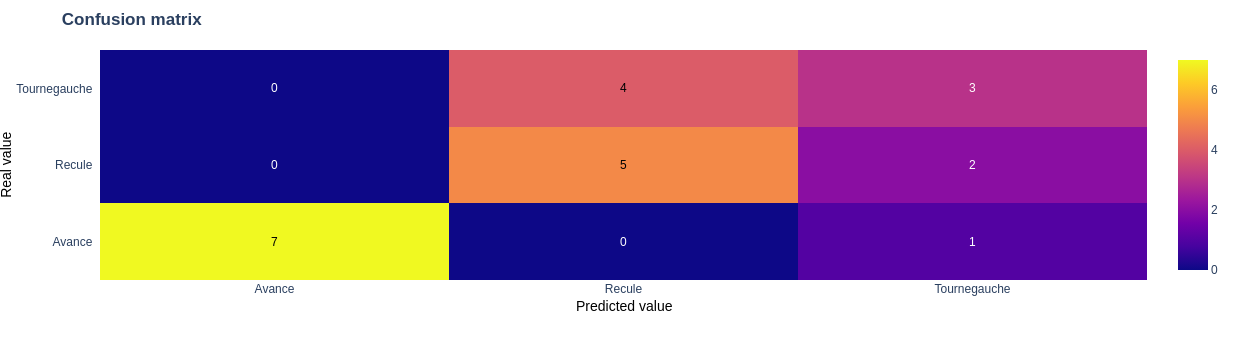

In [26]:
confusion_matrix_clf(clfs_logistic_regression[3], X, y)

### Summary

<div class="alert alert-block alert-info">
We see that the stft + scale transformation works better than the others. In this case, we arrive to identify "avance" but he has difficulty identifying "tourne gauche".</div>

In [36]:
dataframe_model_summary(clfs_logistic_regression)

Pipeline     Score  logistic__C  pca__n_components  \
0         fft pca logistic   0.777778         10.0               15.0   
1  fft scaler pca logistic   0.740741          1.0               20.0   
2            stft logistic   0.777778        500.0                NaN   
3     stft scaler logistic   0.851852          0.5                NaN   

   stft__idx_frequence_max stft__stat  
0                      NaN        NaN  
1                      NaN        NaN  
2                     90.0        max  
3                     95.0       mean

# III) Classification by kernel methods


## Find the best SVM & parameters

As before, we create the param grid for each kernel. And we fit each model.

In [14]:
param_grid_svm_lin = [
{
    "pca__n_components": [15, 20],
    "SVM__kernel": ['linear'],
    "SVM__C": [0.1,0.5,1],
},

{
    "pca__n_components": [15, 17],
    "SVM__kernel": ['linear'],
    "SVM__C": [0.1,0.5,1],
},
    {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [75, 80],
    "SVM__kernel": ['linear'],
    "SVM__C": [1000,2000,3000],
},
{
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90],
    "SVM__kernel": ['linear'],
    "SVM__C": [0.1,0.5,1,],
}]

In [19]:
param_grid_svm_gaus = [
{
    "pca__n_components": [15, 17],
    "SVM__kernel": ['rbf'],
    "SVM__C": [1,10,20,100],
    "SVM__gamma": ['scale', 'auto'] ,
},

{
    "pca__n_components": [15, 17],
    "SVM__kernel": ['rbf'],
    "SVM__C": [1,10,20,100],
    "SVM__gamma": ['scale', 'auto'] ,
},

{
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90],
    "SVM__kernel": ['rbf'],
    "SVM__C": [1,10,100,1000],
    "SVM__gamma": ['scale', 'auto'] ,
},

{
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90],
    "SVM__kernel": ['rbf'],
    "SVM__C": [0.1,1,10,100],
    "SVM__gamma": ['scale', 'auto'] ,
}]

In [16]:
param_grid_svm_poly = [
{
    "pca__n_components": [15, 17],
    "SVM__kernel": ['poly'],
    "SVM__C": [1,10,50,100],
    "SVM__gamma": ['scale', 'auto'],
    "SVM__degree": [3],

},

{
    "pca__n_components": [15, 17],
    "SVM__kernel": ['poly'],
    "SVM__C": [1,10,100,1000],
    "SVM__gamma": ['scale', 'auto'] ,
    "SVM__degree": [3],
},

{
    "stft__stat": [np.max, np.mean, np.median, np.min, np.std],
    "stft__idx_frequence_max": [80, 90],
    "SVM__kernel": ['poly'],
    "SVM__C": [50,100,1000],
    "SVM__gamma": ['scale', 'auto'] ,
    "SVM__degree": [3],
},

{
    "stft__stat": [np.max, np.mean, np.median, np.min, np.std],
    "stft__idx_frequence_max": [80, 90],
    "SVM__kernel": ['poly'],
    "SVM__C": [1,10,50,100],
    "SVM__gamma": ['scale', 'auto'],
    "SVM__degree": [3],
}
]

In [20]:
SVM = SVC(random_state = 42)

In [25]:
clfs_svm_lin = set_pipelines(X, y, SVM, 'SVM', param_grid_svm_lin)

In [21]:
clfs_svm_gaus = set_pipelines(X, y, SVM, 'SVM', param_grid_svm_gaus)

In [23]:
clfs_svm_poly = set_pipelines(X, y, SVM, 'SVM', param_grid_svm_poly)

## Summary

In [29]:
dataframe_model_summary(clfs_svm_gaus + clfs_svm_poly + clfs_svm_lin).sort_values(by=['Score'], ascending = False)

Pipeline     Score  SVM__C SVM__gamma SVM__kernel  \
11     stft scaler SVM   0.851852     0.1        NaN      linear   
10            stft SVM   0.833333  2000.0        NaN      linear   
2             stft SVM   0.814815    10.0      scale         rbf   
3      stft scaler SVM   0.814815   100.0      scale         rbf   
6             stft SVM   0.814815  1000.0      scale        poly   
9   fft scaler pca SVM   0.796296     0.1        NaN      linear   
7      stft scaler SVM   0.777778    50.0      scale        poly   
8          fft pca SVM   0.777778     0.1        NaN      linear   
0          fft pca SVM   0.740741   100.0      scale         rbf   
1   fft scaler pca SVM   0.740741   100.0      scale         rbf   
5   fft scaler pca SVM   0.740741     1.0       auto        poly   
4          fft pca SVM   0.666667    50.0      scale        poly   

    pca__n_components  stft__idx_frequence_max stft__stat  SVM__degree  
11                NaN                     90.0       mean          NaN  
10                NaN                     75.0        max          NaN  
2                 NaN                     80.0       mean          NaN  
3                 NaN                     90.0       mean          NaN  
6                 NaN                     80.0       mean          3.0  
9                15.0                      NaN        NaN          NaN  
7                 NaN                     90.0       mean          3.0  
8                15.0                      NaN        NaN          NaN  
0                15.0                      NaN        NaN          NaN  
1                17.0                      NaN        NaN          NaN  
5                15.0                      NaN        NaN          3.0  
4                17.0                      NaN        NaN          3.0

<div class="alert alert-block alert-info">
We see that the stft + scale transformation with the linear kernel works better than the others. We obtain a score of 85%. There seems to be an overfitting but very slight. With these data, the linear and rbf kernels seem to be more suitable. In general, we obtain better results with a STFT transformation. </div>

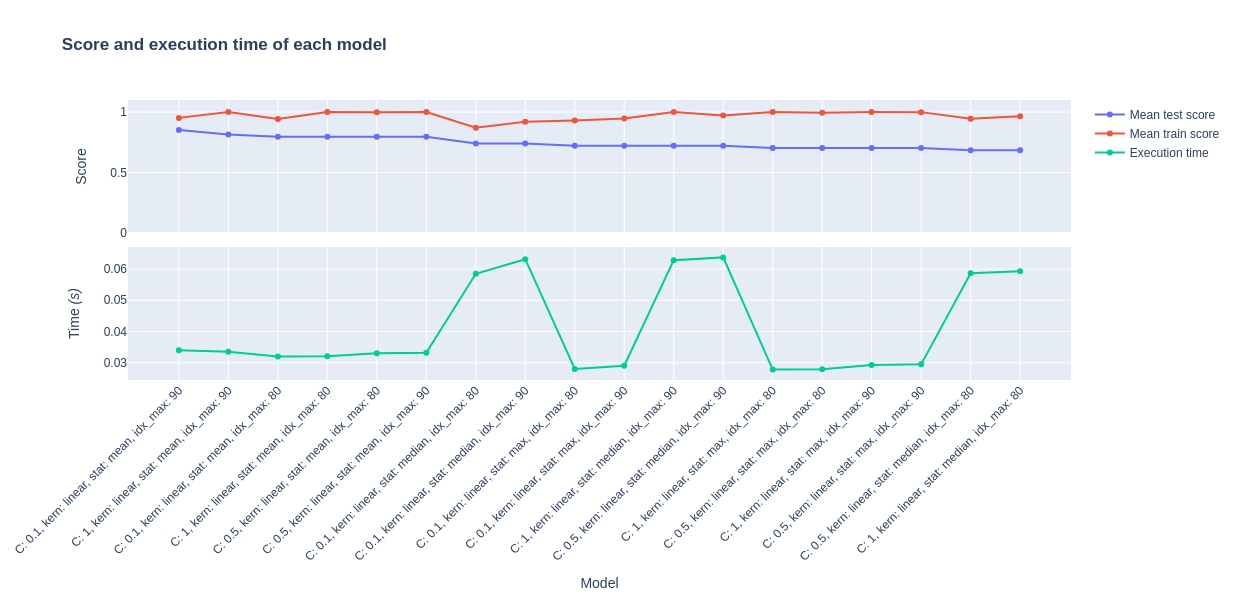

Best parameters: {'SVM__C': 0.1, 'SVM__kernel': 'linear', 'stft__idx_frequence_max': 90, 'stft__stat': <function mean at 0x7baa705e66f0>}
Best score: 0.8518518518518519


In [31]:
plot_score_time_clf(clf_transform(clfs_svm_lin[3], "svm_l4"))

## Borderies visual representation

To display the decision borders, we apply a PCA with 2 dimensions before applying our SVM. It is a large approximation but the objective is just to visualize the effect of the different kernel. So the score will not be high but we don't focus on that.

In [62]:
clf_visu_lin, clf_visu_gaus, clf_visu_poly = clf_visu(X,y)

Best parameters: {'SVM__C': 1, 'SVM__kernel': 'linear'}
Best score: 0.37037037037037035


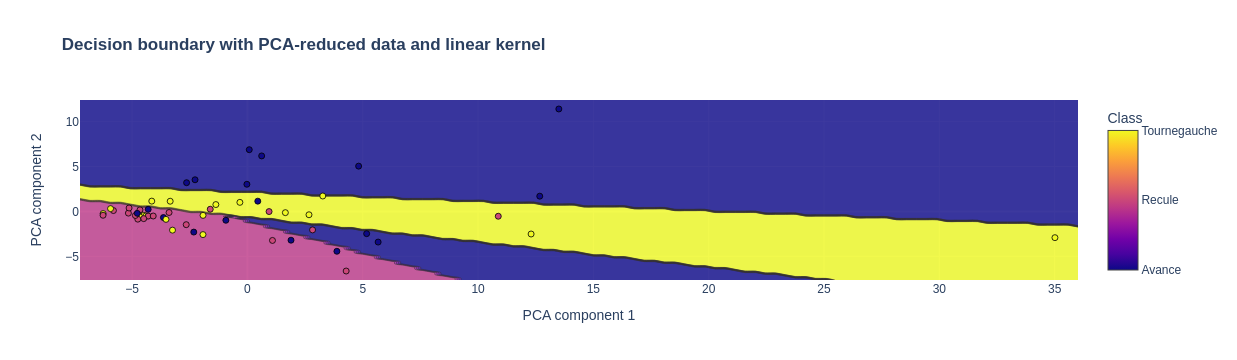

In [55]:
visu_border_svm(clf_visu_lin, X, y)

Best parameters: {'SVM__C': 20, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Best score: 0.3333333333333333


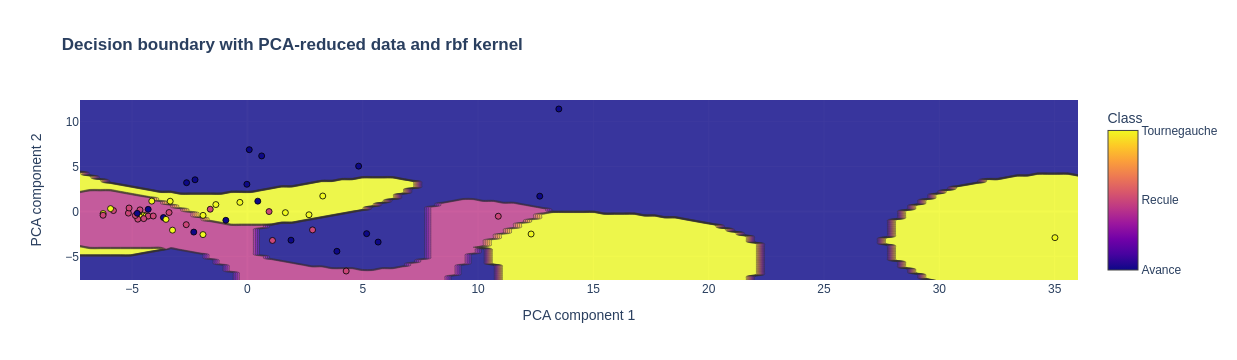

In [63]:
visu_border_svm(clf_visu_gaus, X, y)

Best parameters: {'SVM__C': 0.1, 'SVM__gamma': 'auto', 'SVM__kernel': 'poly'}
Best score: 0.16666666666666666


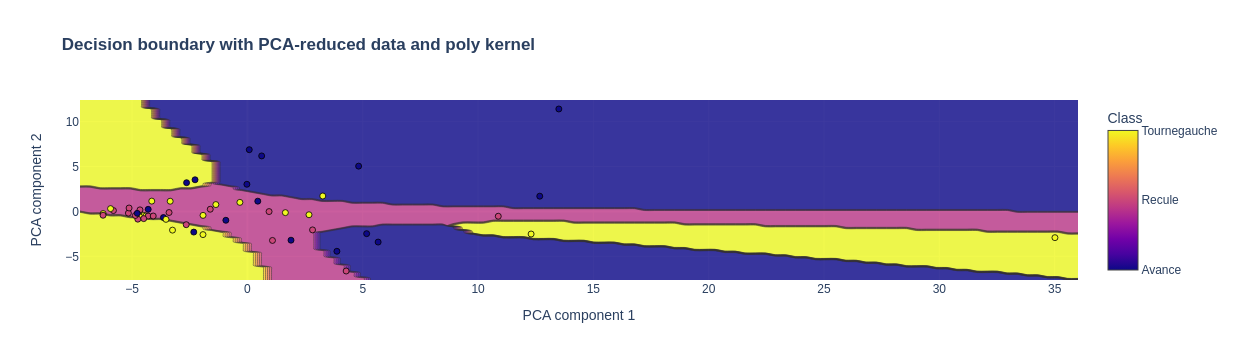

In [64]:
visu_border_svm(clf_visu_poly, X, y)

<div class="alert alert-block alert-info"> 
    
- With the linear kernel, we notice that we have linear decision zones. This creates plans.
- For the Gaussian kernel, the decision zones are kinds of spots. The bigger the C, the more there will be spots.
- And for the polynomial kernel, we obtain polynomial decision zones which can therefore be linear. As we see with the pink part which resembles the linear kernel.

</div>

# VI) Ensemble Method

# V) Neural Network with pytorch

# VI) Clustering

We apply Gaussian mixtures to see if we find the genres and commands clusters. We apply this to two sets of transformed data. And we scale each time.

In [579]:
X_fft = fft_class.transform(X)
X_stft = stft_class.transform(X)
X_fft_scale = scaler.fit_transform(X_fft)
X_stft_scale = scaler.fit_transform(X_stft)
X_fft_pca = pca_test.fit_transform(X_fft_scale)

In [585]:
grid_search_fft, grid_search_stft = gaussian_mixture_grid_search(X)

In [586]:
df_fft, df_stft = df_grid_search(grid_search_fft, grid_search_stft)

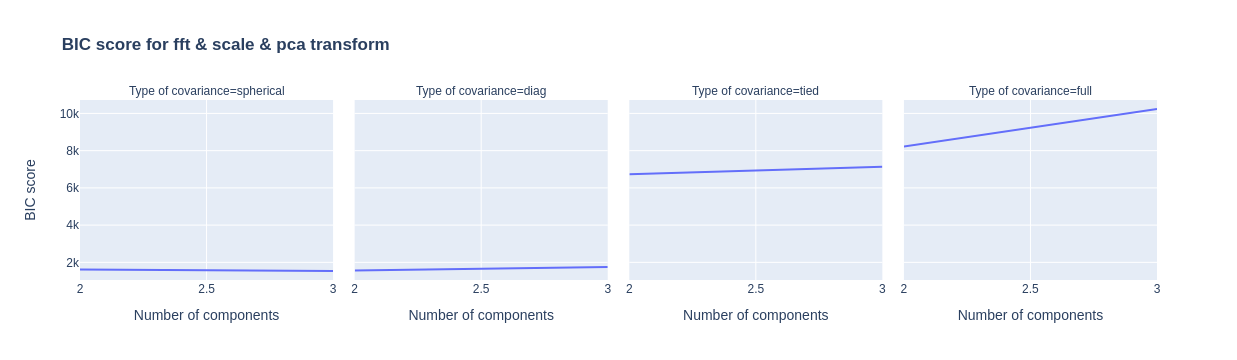

In [587]:
plot_BIC_score(df_fft, 'fft')

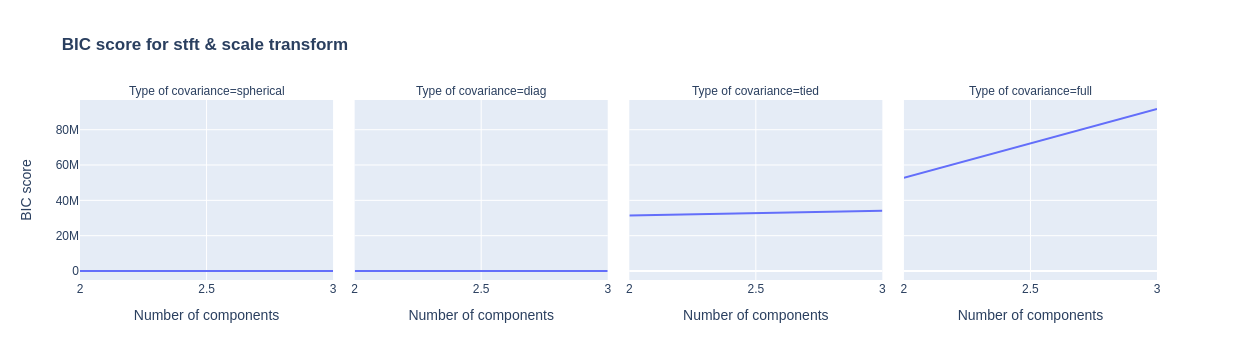

In [588]:
plot_BIC_score(df_stft, 'stft')

<div class="alert alert-block alert-info">
We have more or less the same values ​​of the BIC criterion for 2 or 3 classes. It's random so we find different values ​​each time. But the spherical model is the most suitable for our data. </div>

<div class="alert alert-block alert-info">
We see that we have overall better results with the data transformed by fft with the dataframe below. </div>

In [589]:
(pd.concat([df_fft, df_stft], axis = 0).sort_values(by = ['BIC score']).reset_index(drop=True))

Transform Number of components Type of covariance       Params  \
0   fft & scale & pca                    3          spherical  spherical 3   
1   fft & scale & pca                    2               diag       diag 2   
2   fft & scale & pca                    2          spherical  spherical 2   
3   fft & scale & pca                    3               diag       diag 3   
4        stft & scale                    2          spherical  spherical 2   
5        stft & scale                    3          spherical  spherical 3   
6        stft & scale                    2               diag       diag 2   
7        stft & scale                    3               diag       diag 3   
8   fft & scale & pca                    2               tied       tied 2   
9   fft & scale & pca                    3               tied       tied 3   
10  fft & scale & pca                    2               full       full 2   
11  fft & scale & pca                    3               full       full 3   
12       stft & scale                    2               tied       tied 2   
13       stft & scale                    3               tied       tied 3   
14       stft & scale                    2               full       full 2   
15       stft & scale                    3               full       full 3   

       BIC score  
0   1.535946e+03  
1   1.563144e+03  
2   1.610346e+03  
3   1.747841e+03  
4   2.596130e+03  
5   2.717970e+03  
6   3.229854e+03  
7   3.858153e+03  
8   6.731240e+03  
9   7.131504e+03  
10  8.224354e+03  
11  1.023724e+04  
12  3.146659e+07  
13  3.410276e+07  
14  5.278158e+07  
15  9.172524e+07

<div class="alert alert-block alert-info">
We notice, with the confusion matrices below, that in general we manage to classify one category but then the others are not very correct.</div>

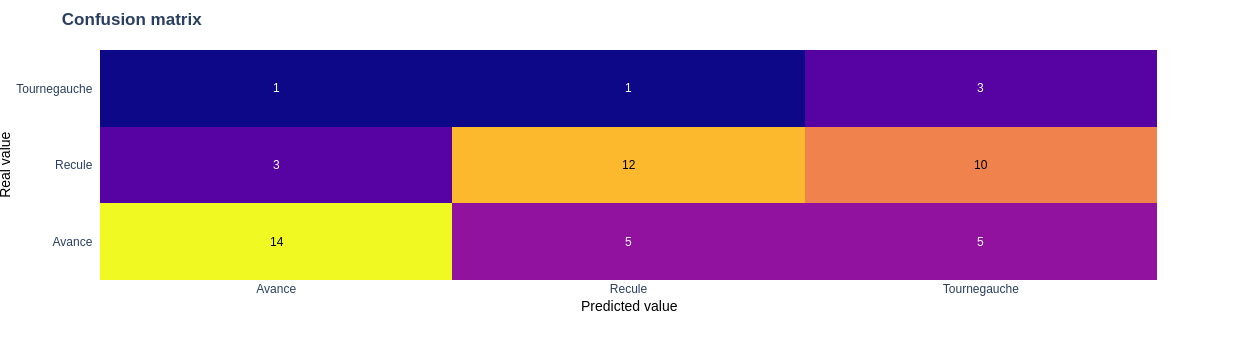

In [595]:
confusion_matrix_clust(grid_search_fft, X_fft_pca)

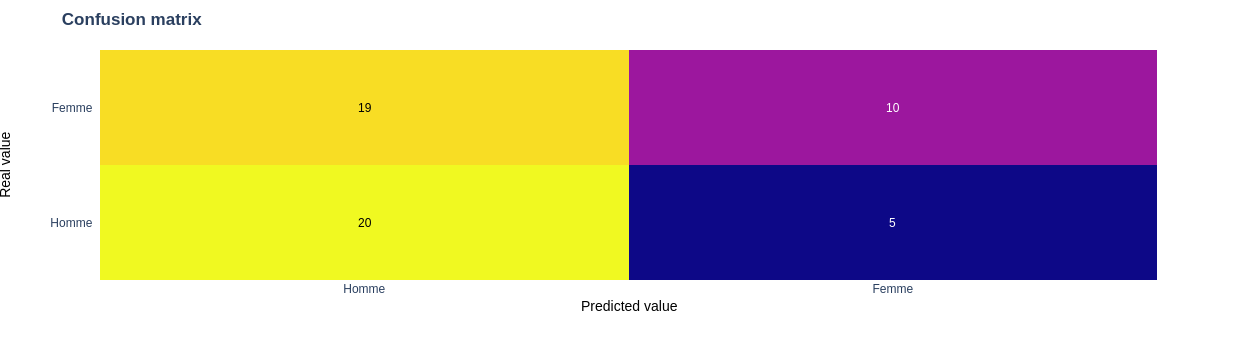

In [591]:
confusion_matrix_clust(grid_search_stft, X_stft_scale)